In [1]:
# 📦 Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
# 📂 Loading the Datasets
ev_sales = pd.read_csv('/kaggle/input/electric-vehicle-dataset-2001-2024/ev_sales_by_makers_and_cat_15-24.csv')
operational_pc = pd.read_csv('/kaggle/input/electric-vehicle-dataset-2001-2024/OperationalPC.csv')
vehicle_class = pd.read_csv('/kaggle/input/electric-vehicle-dataset-2001-2024/Vehicle Class - All.csv')
ev_category = pd.read_csv('/kaggle/input/electric-vehicle-dataset-2001-2024/ev_cat_01-24.csv')
ev_maker_place = pd.read_csv('/kaggle/input/electric-vehicle-dataset-2001-2024/EV Maker by Place.csv')


In [3]:
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*")

In [4]:
# 🧹 Data Cleaning
vehicle_class['Total Registration'] = (
    vehicle_class['Total Registration'].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce')
)

In [5]:
# 📊 Exploratory Data Analysis (EDA)
# 1. Sales Trend Over Years
yearly_sales = ev_sales.drop(columns=['Cat', 'Maker']).sum().reset_index()
yearly_sales.columns = ['Year', 'Total Sales']

In [6]:
# 2. Top 10 EV Makers by Sales
top_ev_makers = (
    ev_sales.assign(Total_Sales=lambda x: x.iloc[:, 2:].sum(axis=1))
    .groupby('Maker')['Total_Sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

In [7]:
# 3. Charging Infrastructure Distribution
charging_distribution = operational_pc.sort_values(by='No. of Operational PCS', ascending=False)


In [8]:
# 🚩 Fixing the FutureWarning by replacing inf values with NaN
yearly_sales.replace([np.inf, -np.inf], np.nan, inplace=True)
top_ev_makers.replace([np.inf, -np.inf], np.nan, inplace=True)
charging_distribution.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
# 🚩 Fixing FutureWarning by replacing inf with NaN and dropping NaN values
yearly_sales.replace([np.inf, -np.inf], np.nan, inplace=True)
top_ev_makers.replace([np.inf, -np.inf], np.nan, inplace=True)
charging_distribution.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any remaining NaN values (optional but recommended for clean plots)
yearly_sales.dropna(inplace=True)
top_ev_makers.dropna(inplace=True)
charging_distribution.dropna(inplace=True)


# EV Sales Trend in India (2015–2024)

This plot shows the growth of EV sales over the years, 

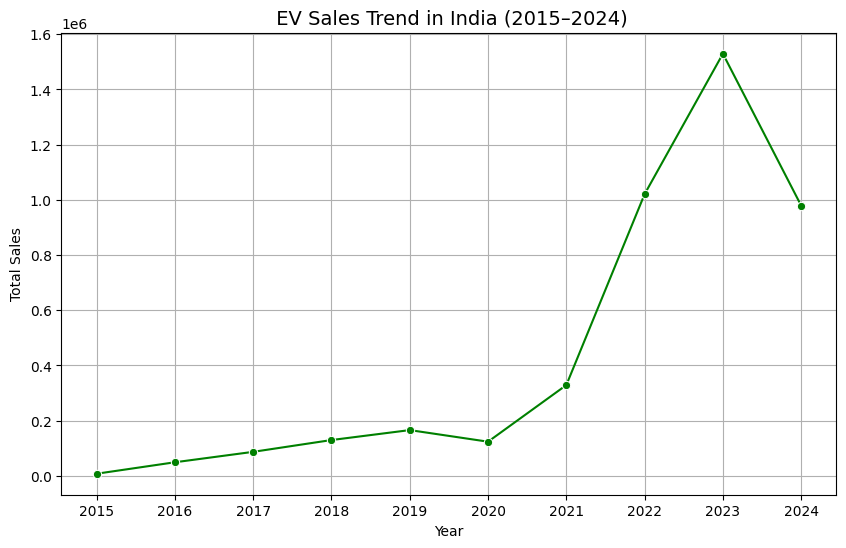

In [10]:
# 🚩 EV Sales Trend in India (2015–2024)
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sales, x='Year', y='Total Sales', marker='o', color='green')
plt.title(' EV Sales Trend in India (2015–2024)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Top 10 EV Makers by Total Sales
 
This horizontal bar plot highlights the top EV manufacturers based on their total sales volume.

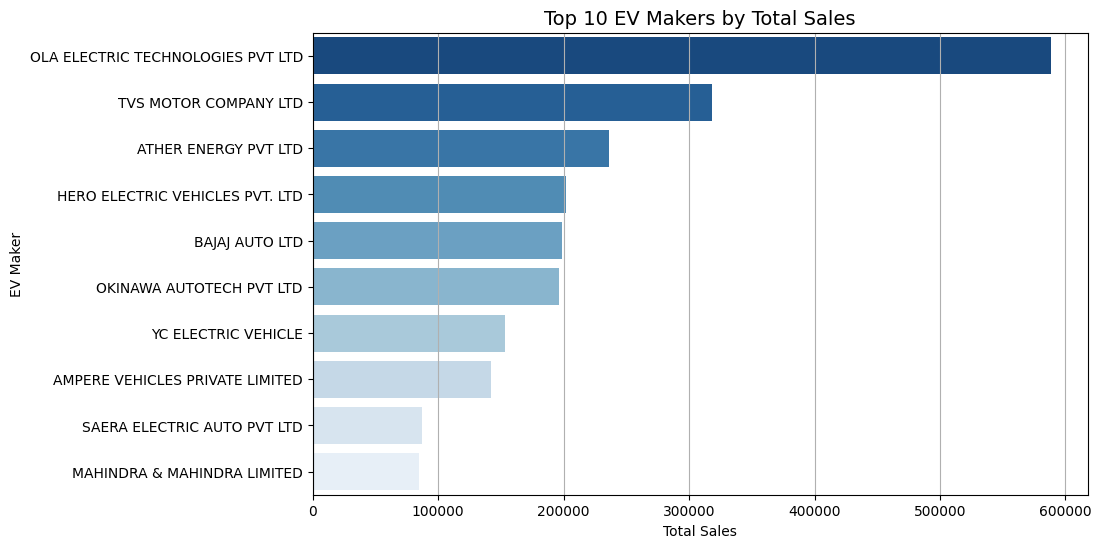

In [11]:
# 🚗 Top 10 EV Makers by Total Sales
plt.figure(figsize=(10, 6))
sns.barplot(y=top_ev_makers.index, x=top_ev_makers.values, palette='Blues_r')
plt.title('Top 10 EV Makers by Total Sales', fontsize=14)
plt.xlabel('Total Sales')
plt.ylabel('EV Maker')
plt.grid(axis='x')
plt.show()


# Top 10 States with Public Charging Stations

This plot showcases the leading states with the highest number of operational public charging stations, crucial for EV adoption.

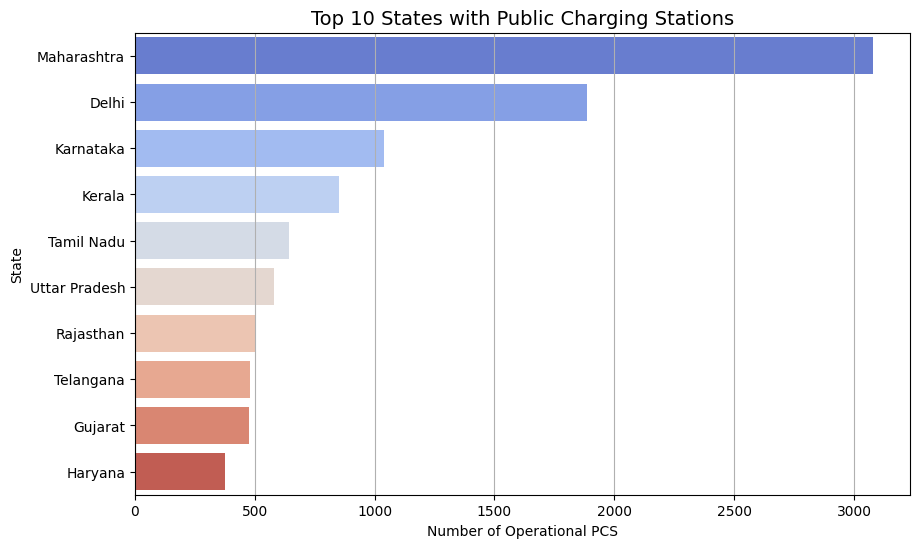

In [12]:
# ⚡ Top 10 States with Public Charging Stations
plt.figure(figsize=(10, 6))
sns.barplot(data=charging_distribution.head(10), 
            x='No. of Operational PCS', 
            y='State', 
            palette='coolwarm')
plt.title('Top 10 States with Public Charging Stations', fontsize=14)
plt.xlabel('Number of Operational PCS')
plt.ylabel('State')
plt.grid(axis='x')
plt.show()


In [13]:
# 🔍 Market Segmentation
# Merging EV Sales with Charging Infrastructure
state_sales = (
    ev_sales.merge(ev_maker_place, left_on='Maker', right_on='EV Maker', how='left')
    .groupby('State')
    .agg({str(year): 'sum' for year in range(2015, 2025)})
    .reset_index()
    .dropna()
)

In [14]:

# ✅ Define segmentation_data
segmentation_data = state_sales.merge(operational_pc, on='State', how='outer').fillna(0)


In [15]:
# 🚀 Clustering with K-Means
features = segmentation_data.drop(columns=['State'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [16]:
# 🚀 Clustering with K-Means (Fix for Warning)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  
segmentation_data['Cluster'] = kmeans.fit_predict(scaled_features)


In [17]:
# 🎯 PCA for Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)


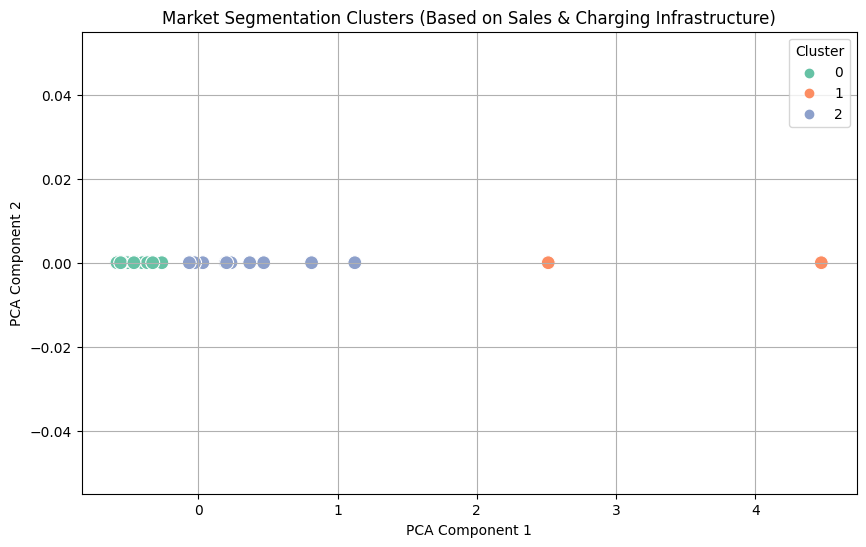

In [18]:

# Cluster Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=segmentation_data['Cluster'], palette='Set2', s=100)
plt.title('Market Segmentation Clusters (Based on Sales & Charging Infrastructure)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [19]:

# 📑 Key Insights (Table Format)
# Display cluster information
for cluster in segmentation_data['Cluster'].unique():
    cluster_states = segmentation_data[segmentation_data['Cluster'] == cluster]['State'].tolist()
    print(f"Cluster {cluster}: {len(cluster_states)} States -> {', '.join(cluster_states)}")

Cluster 0: 21 States -> Andaman & Nicobar, Arunachal Pradesh, Assam, Bihar, Chandigarh, Chhattisgarh, D&D and DNH, Goa, Himachal Pradesh, Jammu and Kashmir, Jharkhand, Lakshadweep, Manipur, Meghalaya, Nagaland, Odisha, Pondicherry, Punjab, Sikkim, Tripura, Uttarakhand
Cluster 2: 11 States -> Andhra Pradesh, Gujarat, Haryana, Karnataka, Kerala, Madhya Pradesh, Rajasthan, Tamil Nadu, Telangana, Uttar Pradesh, West Bengal
Cluster 1: 2 States -> Delhi, Maharashtra


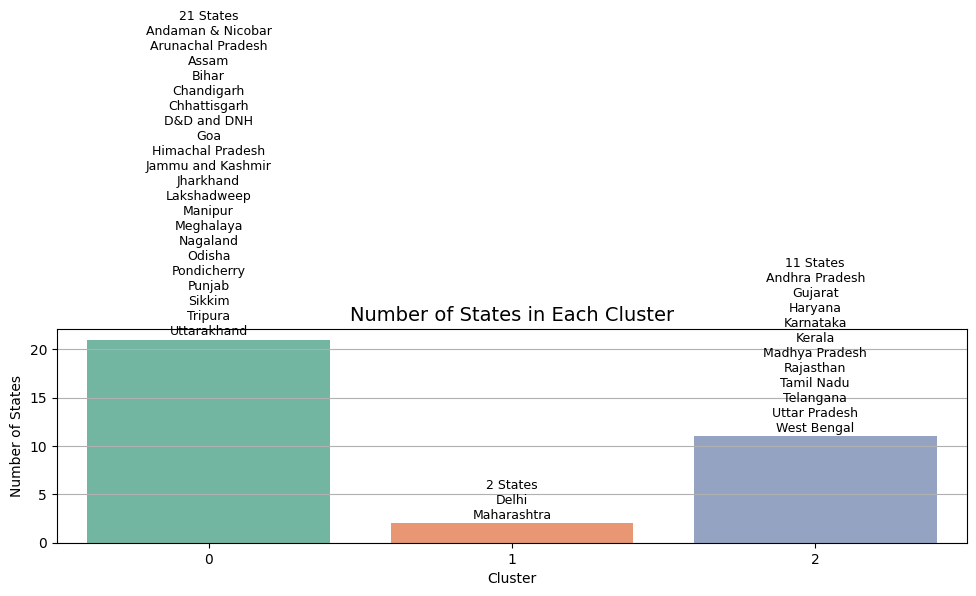

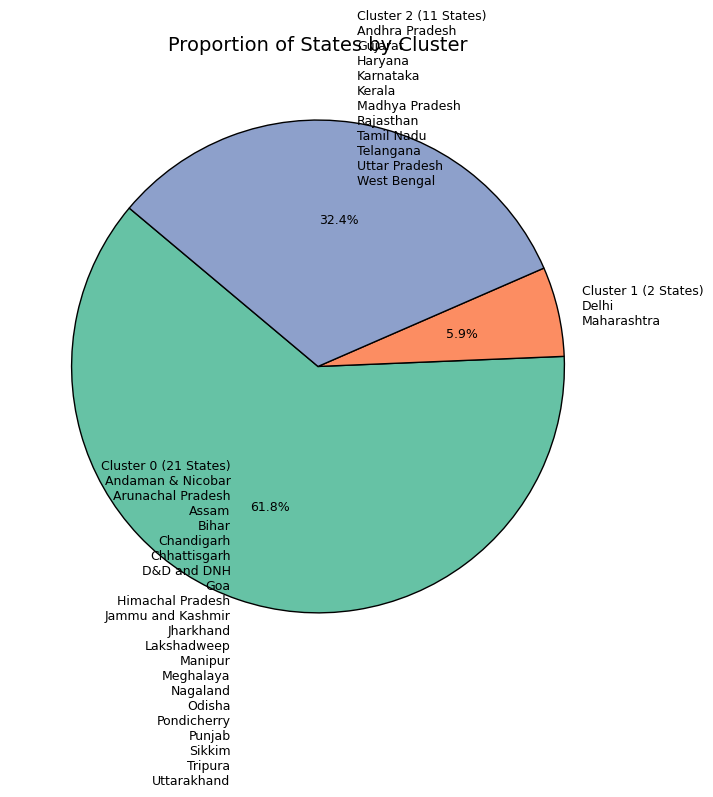

In [20]:
# 📋 Preparing Data for Visualization
cluster_summary = segmentation_data.groupby('Cluster')['State'].apply(list).reset_index()
cluster_summary['Number of States'] = cluster_summary['State'].apply(len)

# 🎨 Color Palette for Consistency
colors = sns.color_palette('Set2', len(cluster_summary))

# 📊 Bar Chart: Number of States in Each Cluster with State Names (Vertical List)
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Cluster', y='Number of States', data=cluster_summary, palette=colors)
plt.title('Number of States in Each Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Number of States')
plt.grid(axis='y')

# Adding state names as vertical lists above each bar
for index, row in cluster_summary.iterrows():
    states_list = "\n".join(row['State'])  # Join state names vertically
    barplot.text(index, row['Number of States'] + 0.5, f"{row['Number of States']} States\n{states_list}", 
                 color='black', ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# 🗺️ Pie Chart: Proportion of States by Cluster with Vertical State Lists
plt.figure(figsize=(10, 8))
plt.pie(cluster_summary['Number of States'], 
        labels=[f"Cluster {row['Cluster']} ({row['Number of States']} States)\n" + "\n".join(row['State']) 
                for _, row in cluster_summary.iterrows()], 
        autopct='%1.1f%%', 
        colors=colors,
        startangle=140,
        wedgeprops=dict(edgecolor='black'),
        textprops={'fontsize': 9})  # Adjusting text size for readability

plt.title('Proportion of States by Cluster', fontsize=14)
plt.show()


<Figure size 1200x600 with 0 Axes>

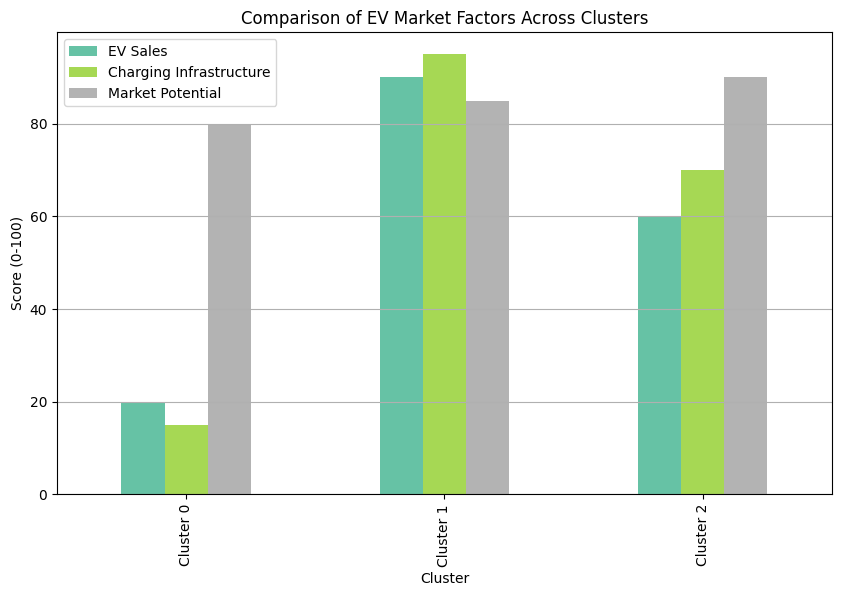

In [21]:
# Preparing Data
cluster_comparison = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2'],
    'EV Sales': [20, 90, 60],
    'Charging Infrastructure': [15, 95, 70],
    'Market Potential': [80, 85, 90]  # Hypothetical scoring for illustration
}

import pandas as pd
df_cluster = pd.DataFrame(cluster_comparison)

# Plotting
plt.figure(figsize=(12, 6))
df_cluster.set_index('Cluster').plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Comparison of EV Market Factors Across Clusters')
plt.ylabel('Score (0-100)')
plt.grid(axis='y')
plt.show()